The codes provided in this notebook are based on analytical analyses in [Feigelson & Nelson (1985)](https://ui.adsabs.harvard.edu/abs/1985ApJ...293..192F/abstract). The method used here is called nonparametric univariate survival analysis based on Keplan-Meier product-limit (PL) estimtor and Gehan or Logrank two-sample tests. It is designed to answer this following question: 

#### I have two left-censored univariate datasets, say, data1 {$x_i$}, i=1, 2, .., N1 and data2 {$x_j$}, j=1, 2, ..., N2, both datasets have detections and upper limits. What is the possibility that data1 and data2 are drawn from the same (unknown) distribution? 

Null hypothesi $H_0$: data1 and data2 are drawn from the same (unknown) distribution. <br>
Alternative hypothesis $H_1$: data1 and data2 are NOT drawn from the same (unknown) distribution. <br>
We seek to reject $H_0$ at significance level of p (usually, p is expected to be <0.05). 

#### Before you proceed, here are a few things to keep in mind. For more detailed discussion, please refer to Section V in FN85. 
* When the sample is very small (N<=10) or very heavily censored (>90% of the data points are upper limits), Gehan and Logrank tests give unreliable results. 
* This notebook is designed to process astronomy datasets with upper limits. However, if your datasets have lower limits instead (e.g., saturation), you can still use this notebook with some twists. I'll explain later. 
* Upper limits in astronomy datasets could be quoted as $1\sigma$, $2\sigma$.... $5\sigma$ values. As FN85 put it, "There is no unique value assignale to this situation" 
* The method provided in this notebook can not deal with datasets with both upper and lower limits. I haven't been able to find a method that can account for both, if you know one, please let me know! (Thanks!)
* If you are want to test whether a censored data sample is drawn from a specified analytical model (say, linear, lognormal, exponential), then try "Goodness-of-fit" tests, such as Person's $\chi^2$ statistic and the modified KS test. Although, note that modified KS test for randomly censored data are proved to be somewhat difficult. Anyway, none of these is covered in this notebook. If you want to apply regression techniques to a censored dataset, check out this paper: [Isobe, Feigelson, Nelson (1986)](https://ui.adsabs.harvard.edu/abs/1986ApJ...306..490I/abstract).

#### Here is the structure of the notebook. Each part can stand alone by itself. You do not need to run Part A to get to B or C, vice versa. 
* All the functions are stored in survival_analysis_yz.py
* Part A: Build codes based on FN85, and test the codes with one of the examples given by FN85. <br>
* Part B: a real example on how to run the codes to test $H_0$ on two astronomical datasets.  <br>
* Part C: A demonstration on what happens if testing $H_0$ with the two-sample KS test, but do not use upper limits or treat the limits as values. 

## Part A: built the code and test it with an example from FN85
 

#### Null hypothesis $H_0$: we have two left-censored datasets, $\{x^L\}_{i1}^{n1}$ and $\{x^L\}_{i2}^{n2}$, and the distribution functions of the two datasets are the same, i.e., $F_1^L(x)$ = $F_2^L(x)$, for all x. See page 3 in FN95. 

FN85 suggested that astronomy datasets, if left-censored (i.e., upper limits), can be transformed into right-censored problem by subtracting all the values in the datasets by a constant value M. <br>

For example, we have a dataset $\{x^L\}_i^n$=[30, <24, 11, <19, 27, 11, 24, <28], with i=1, 2, .., 8. This is also the same example given by FN95. Here the superscript "L" means the data is left-censored. We choose M=30 (the largest value in the dataset, could also be 31, 100, 1000, as long as the value is higher or equal to the maximum of the dataset), and transform $\{x^L\}_i^n$ into $\{x^R\}_i^n$ = [0, >6, 19, >11, 3, 19, 6, >2], and now the dataset is right-centered (lower limit), denoted with R. See Eq 2 in FN95. <br>

#### Below we construct two left-censored datasets, and transformed them into right-censored ones. 
If your data are right-censored already (contains lower limits), then you can skip this step, name your datasets as xR_1, xR_2 directly. 

In [1]:
import numpy as np 

# select to be a constant larger or equal to the maximum value of the two data sets 
max_val = 30 

# these two datasets are taken from section III in FN85
# data set 1
xL_1 = np.array([30, 24, 11, 19, 27, 11, 24, 28]) 
xR_1 = max_val - xL_1 # transform the dataset into right-censored form 
delta_1 = np.array([1, 0, 1, 0, 1, 1, 1, 0]) # 1 means detection, 
                                             # 0 mean upper limit in xL_1, or lower limit in xR_1

# data set 2 
xL_2 = np.array([3, 23, 17, 8, 10, 5])
xR_2 = max_val - xL_2 
delta_2 = np.array([1, 1, 0, 0, 1, 0])

In [2]:
# for consistency, hereafter, I'm gonna use data1, delta1, data2, delta2 instead 
data1 = xR_1.copy()  # use the copy() in case data1 is modified, xR_1 is still fine 
delta1 = delta_1.copy()
data2 = xR_2.copy()
delta2 = delta_2.copy()

#### We want to calculate $n_{1j}$, $n_{2j}$, $n_{j}$, $m_{1j}$, $m_{2j}$, $m_{j}$, $d_{1j}$, $d_{2j}$, $d_{j}$, $w^{Gehan}_{j}$, $w^{Logrank}_{j}$ following Eq. 17 & 19 in FN85. 

First, find out all the distinct uncensored values in the combined samples and arrange in ascending order, $y_1<y_2<y_3...<y_r$, $r\leq(N1+N2)$, where N1 and N2 are the sample sizes of data1 and data2, respectively. 

In [3]:
from survival_analysis_yz import unique_sorted_detection 

uni_y = unique_sorted_detection(data1, delta1, data2, delta2)

Second, for each distinct $y_i$ value, calculate the number of observations ($n_{\rm 1j}$) from data1 larger or equal to $y_i$. See Eq 17 in FN85. Same for data2. And $n_j = n_{1j}+n_{2j}$

In [4]:
from survival_analysis_yz import calc_n1j_n2j_nj

n1j, n2j, nj = calc_n1j_n2j_nj(data1, delta1, data2, delta2)

Third, for each distinct $y_i$ value, calculate the number of censored observations ($m_{\rm 1j}$) from data1 with values between $y_i$ and $y_{i+1}$. See Eq 17 in FN85. Same for data2. And $m_j = m_{1j}+m_{2j}$. If there are ties between censored and uncensored observations, we consider the censored values to be larger (see the sentence above Eq 8 in FN85). In the example we are using now, data1 include a censored value of $>6$ and a uncensored value of 6. We do not consider the uncensored 6 when counting $m_{1j}$. In the case of counting $d_{1j}$ (see next point), we will count the uncensored 6, but not the censored $>6$. 

In [5]:
from survival_analysis_yz import calc_m1j_m2j_mj 

m1j, m2j, mj = calc_m1j_m2j_mj(data1, delta1, data2, delta2)

Fourth, for each distinct $y_i$ value, calculate the number of uncensored observations ($d_{\rm 1j}$) from data1 with values equal to $y_i$. See Eq 17 in FN85. Same for data2. And $d_j = d_{1j}+d_{2j}$.

In [6]:
from survival_analysis_yz import calc_d1j_d2j_dj

d1j, d2j, dj = calc_d1j_d2j_dj(data1, delta1, data2, delta2)

Then, calculate the Gehan and Logrank statistics: $L_n=\Sigma_{j=1}^r w_j (d_{1j}-d_j n_{1j}/n_j)$, where {$w_j$} are weights defined $w_j=n_j, j=1, 2, ..., r$ if Gehan, or $w_j=1, j=1, 2, ..., r$ if Logrank. See Eq 19 in FN85. 

In [7]:
from survival_analysis_yz import calc_wj_Gehan
wj_Gehan = calc_wj_Gehan(data1, delta1, data2, delta2)

from survival_analysis_yz import calc_wj_Logrank
wj_Logrank = calc_wj_Logrank(data1, delta1, data2, delta2)

#### OK! now apply these functions to reproduce Table 3A in FN85. 

In [64]:
# write data into a table 
from astropy.table import QTable
tb3a_FN95 = QTable([uni_y, n1j, n2j, nj, m1j, m2j, mj, d1j, d2j, dj, wj_Gehan, wj_Logrank],
            names=('yj', 'n1j', 'n2j', 'nj', 'm1j', 'm2j', 'mj', 'd1j', 'd2j', 'dj', 
                   'wj_Gehan', 'wj_Logrank'))
tb3a_FN95

yj,n1j,n2j,nj,m1j,m2j,mj,d1j,d2j,dj,wj_Gehan,wj_Logrank
int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
0,8,6,14,1,0,1,1,0,1,14,1
3,6,6,12,0,0,0,1,0,1,12,1
6,5,6,11,1,0,1,1,0,1,11,1
7,3,6,9,1,1,2,0,1,1,9,1
19,2,4,6,0,0,0,2,0,2,6,1
20,0,4,4,0,2,2,0,1,1,4,1
27,0,1,1,0,0,0,0,1,1,1,1


#### Now let's reproduce Table 3B. 

In [10]:
from survival_analysis_yz import calc_Ln, calc_sigman_sq 

weight = 'Gehan'# Gehan or Logrank 
Ln_j_G, Ln_G = calc_Ln(data1, delta1, data2, delta2, weight=weight)
sigman_sq_j_G, sigman_sq_G = calc_sigman_sq(data1, delta1, data2, delta2, weight=weight)
sigman_G = np.sqrt(sigman_sq_G)
print('(Gehan): Ln=%.4f+/-%.4f'%(Ln_G, sigman_G))

weight = 'Logrank'# Gehan or Logrank 
Ln_j_L, Ln_L = calc_Ln(data1, delta1, data2, delta2, weight=weight)
sigman_sq_j_L, sigman_sq_L = calc_sigman_sq(data1, delta1, data2, delta2, weight=weight)
sigman_L = np.sqrt(sigman_sq_L)
print('(Logrank): Ln=%.4f+/-%.4f'%(Ln_L, sigman_L))

from astropy.table import QTable
tb3b_FN95 = QTable([uni_y, Ln_j_G, Ln_j_L],
            names=('yj', 'Ln_j_Gehan', 'Ln_j_Logrank'))
tb3b_FN95

(Gehan): Ln=23.0000+/-12.0333
(Logrank): Ln=2.4740+/-1.1492


/Users/Yong/Dropbox/GitRepo/survival_analysis/survival_analysis_yz.py:206: RuntimeWarning: invalid value encountered in true_divide
  sigman_sq_j = dj*(wj**2)*(n1j/nj)*(n2j/nj)*(nj-dj)/(nj-1)


yj,Ln_j_Gehan,Ln_j_Logrank
int64,float64,float64
0,6.0,0.4285714285714286
3,6.0,0.5
6,6.0,0.5454545454545454
7,-3.0,-0.3333333333333333
19,8.0,1.3333333333333335
20,0.0,0.0
27,0.0,0.0


#### Lastly, calculate the p-value to test $H_0$, yeah! <br>
Specifically, we have, $|L_n/\hat{\sigma_n}|\geq z_{\alpha/2}$, according to FN95, "$z_{\alpha/2}$ is the score such that the area under a standard normal curve over the interval [$-z_{\alpha/2}$, $z_{\alpha/2}$] is $1-\alpha$. The attained significance level of the test is the area under a standard normal curve over the region on the norizontal axis greater than $|L_n/\hat{\sigma_n}|$. " This translates into the following lines: 

In [11]:
from survival_analysis_yz import calc_p_value

p_G = calc_p_value(Ln_G, sigman_G, weight='Gehan')
p_L = calc_p_value(Ln_L, sigman_L, weight='Logrank')

Gehan test finds p=0.0510793004 to reject H0

Logrank test finds p=0.0314843879 to reject H0



#### OK! now let's put all the code together into one piece. 

In [10]:
from survival_analysis_yz import two_sample_test_censored_data
data1 = xL_1.copy()  
delta1 = delta_1.copy()
data2 = xL_2.copy()
delta2 = delta_2.copy()

p_G = two_sample_test_censored_data(data1, delta1, data2, delta2, weight='Gehan', censored_type='upper_limit')
P_L = two_sample_test_censored_data(data1, delta1, data2, delta2, weight='Logrank', censored_type='upper_limit')

Gehan: Ln=23.0000+/-12.0333
Gehan test finds p=0.0510793004 to reject H0
>> Warnin: one or both of the datasets have sample size <=10, this test maybe unreliable.
Logrank: Ln=2.4740+/-1.1492
Logrank test finds p=0.0314843879 to reject H0
>> Warnin: one or both of the datasets have sample size <=10, this test maybe unreliable.


## Part B: apply survival_analysis_yz.py to some astronomy data  <br>

Here I'm going to use two datasets from [Bordoloi+2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...796..136B/abstract) and [Liang+2014](https://ui.adsabs.harvard.edu/abs/2014MNRAS.445.2061L/abstract), both of which study the CGM of dwarf galaxies. We are going to test the null hypothesis: the Equivalent wdiths ($W_r$) of CIV measured in these two studies are drawn from the same absorber population. 

In [1]:
from astropy.table import Table 
import numpy as np 
import matplotlib.pyplot as plt 

import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'

In [2]:
bord14 = Table.read('tables/Bordoloi14_tb1_Wr_CIV.txt', format='ascii')
b14_r = bord14['R']
b14_Wr = bord14['Wr']  # in unit of mA
b14_eWr = bord14['eWr'] # if nan, then Wr is 1sig limit 

b14_delta = np.isfinite(b14_eWr).astype('int') # 1=detection, 0=non-detection 

In [7]:
liang14 = Table.read('tables/Liang14_table4_Wr_CIV.dat', format='ascii')
l14_Wr = liang14['Wr_CIV']
l14_eWr =liang14['eWr_CIV']
l14_r = liang14['d_kpc']

l14_uplims = l14_Wr == '<='
l14_Wr[l14_uplims] = 'nan'
l14_Wr = np.asarray(l14_Wr, dtype='float')
l14_Wr[l14_uplims] = l14_eWr[l14_uplims]/2.  # because they quote 2 sigma, I'm going to divide their value by 2 

l14_delta = (np.logical_not(l14_uplims)).astype('int')  # 1=detection, 0=non-detection 

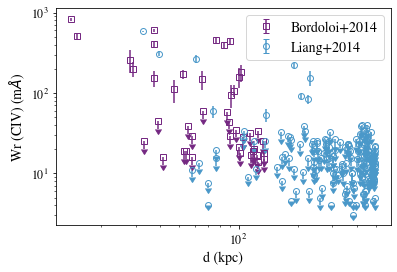

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

# add bordoloi+2014 if CIV 
uplims = np.isnan(b14_eWr)
yerr = b14_eWr.copy()
yerr[uplims] = b14_Wr[uplims]/5.
ax.errorbar(b14_r, b14_Wr, yerr=yerr, uplims=uplims, 
            fmt='s', markeredgecolor=plt.cm.PRGn(0.1), markerfacecolor='none', 
            color=plt.cm.PRGn(0.1), label='Bordoloi+2014')

# add Liang+2014 
uplims = l14_uplims
yerr = l14_eWr.copy()
yerr[uplims] = l14_Wr[uplims]/5.
ax.errorbar(l14_r, l14_Wr, yerr=yerr, uplims=uplims, fmt='o', 
            markeredgecolor=plt.cm.Blues(0.6), markerfacecolor='none', 
            color=plt.cm.Blues(0.6), label='Liang+2014', markersize=6)

ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('d (kpc)', fontsize=14)
ax.set_ylabel(r'Wr (CIV) (m$\AA$)', fontsize=14)
a = plt.xticks(fontsize=12)
a = plt.yticks(fontsize=12)

Hereafter, we refer to Bordoloi+2014's dataset as data1, and that from Linag+2014 as data2. 

In [9]:
data1 = np.asarray(b14_Wr) # upper limits, left censored 
delta1 = np.asarray(b14_delta)
data2 = np.asarray(l14_Wr)
delta2 = np.asarray(l14_delta)

In [10]:
from survival_analysis_yz import two_sample_test_censored_data
p_G = two_sample_test_censored_data(data1, delta1, data2, delta2, weight='Gehan', censored_type='upper_limit')

p_L = two_sample_test_censored_data(data1, delta1, data2, delta2, weight='Logrank', censored_type='upper_limit')

Gehan: Ln=2407.0000+/-372.1223
Gehan test finds p=0.0000000001 to reject H0

>> Warning: one or both of the datasets are heavily censored (>90 percent of values are limits), Gehan maybe unreliable.

Logrank: Ln=12.4462+/-1.9349
Logrank test finds p=0.0000000001 to reject H0

>> Warning: one or both of the datasets are heavily censored (>90 percent of values are limits), Logrank maybe unreliable.



### Part C: what happen if you use a two-sample KS test but do not include upper/lower limits, or treat the limits as detection values. 
Here we use scipy.stat.ks_2samp to test whether data1 from Bordoloi+2014 and data2 from Liang+2014 are drawn from the same populuation. 

In [11]:
from astropy.table import Table 
import numpy as np 
import matplotlib.pyplot as plt 

import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'

In [12]:
bord14 = Table.read('tables/Bordoloi14_tb1_Wr_CIV.txt', format='ascii')
b14_r = bord14['R']
b14_Wr = bord14['Wr']  # in unit of mA
b14_eWr = bord14['eWr'] # if nan, then Wr is 1sig limit 

b14_delta = np.isfinite(b14_eWr).astype('int') # 1=detection, 0=non-detection 

In [13]:
liang14 = Table.read('tables/Liang14_table4_Wr_CIV.dat', format='ascii')
l14_Wr = liang14['Wr_CIV']
l14_eWr =liang14['eWr_CIV']
l14_r = liang14['d_kpc']

l14_uplims = l14_Wr == '<='
l14_Wr[l14_uplims] = 'nan'
l14_Wr = np.asarray(l14_Wr, dtype='float')
l14_Wr[l14_uplims] = l14_eWr[l14_uplims]/2.  # because they quote 2 sigma, I'm going to divide their value by 2 

l14_delta = (np.logical_not(l14_uplims)).astype('int')  # 1=detection, 0=non-detection 

In [16]:
data1 = np.asarray(b14_Wr) # upper limits, left censored 
delta1 = np.asarray(b14_delta)
data2 = np.asarray(l14_Wr)
delta2 = np.asarray(l14_delta)

#### Approach I: we only use detection values, and ignore those upper limits in both datasets.

In [18]:
data1_uncensored = data1[delta1==1]
data2_uncensored = data2[delta2==1]

from scipy import stats
D_val, p_val = stats.ks_2samp(data1_uncensored, data2_uncensored)
print("p: ", p_val)

p:  0.12256356915395816


#### Approach II: we treat the limits in the datasets as values. 

In [19]:
data1_use_limits = data1
data2_use_limits = data2

from scipy import stats
D_val, p_val = stats.ks_2samp(data1_use_limits, data2_use_limits)
print("p: ", p_val)

p:  2.1738107647273353e-08


Conclusion: Try 1 and Try 2 give very different p values compared to the Gehan or Logrank two-sample tests I implement here. For each specific problems, KS test may or may not give correct answers with approach I or II. Meanwhile, all these three tests may be subject to small number statistics. 